# KDE for Foreground Detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time

# Set random seed for reproducibility
np.random.seed(42)

## Image preprocessing functions 

In [2]:
def load_and_preprocess_images(bg_path, test_path, target_size=(400, 400)):
    """
    Load and preprocess background and test images.
    
    Parameters:
    -----------
    bg_path : str
        Path to background image
    test_path : str
        Path to test image
    target_size : tuple
        Target dimensions (height, width) for resizing
    
    Returns:
    --------
    bg_img : numpy array
        Preprocessed background image
    test_img : numpy array
        Preprocessed test image
    """
    # Load images
    bg_img = Image.open(bg_path)
    test_img = Image.open(test_path)
    
    # Resize to target size for computational efficiency
    bg_img = bg_img.resize((target_size[1], target_size[0]), Image.BILINEAR)
    test_img = test_img.resize((target_size[1], target_size[0]), Image.BILINEAR)
    
    # Convert to numpy arrays
    bg_img = np.array(bg_img)
    test_img = np.array(test_img)
    
    # Normalize to [0, 1] range
    bg_img = bg_img.astype(np.float32) / 255.0
    test_img = test_img.astype(np.float32) / 255.0
    
    return bg_img, test_img


def extract_features(image, feature_type='rgb'):
    """
    Extract features from image for KDE.
    
    Parameters:
    -----------
    image : numpy array
        Input image (H x W x C)
    feature_type : str
        Type of features to extract: 'rgb', 'grayscale', or 'rgb_normalized'
    
    Returns:
    --------
    features : numpy array
        Extracted features (N x D) where N is number of pixels, D is feature dimension
    """
    h, w = image.shape[:2]
    
    if feature_type == 'rgb':
        # Use RGB channels directly
        features = image.reshape(-1, 3)
    
    elif feature_type == 'grayscale':
        # Convert to grayscale
        if len(image.shape) == 3:
            grayscale = 0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 2]
        else:
            grayscale = image
        features = grayscale.reshape(-1, 1)
    
    elif feature_type == 'rgb_normalized':
        # RGB with intensity normalization (more robust to lighting changes)
        features = image.reshape(-1, 3)
        intensity = np.linalg.norm(features, axis=1, keepdims=True) + 1e-8
        features = features / intensity
    
    return features


### Preprocessing Approach & Justification

#### 1. Image Alignment and Resizing

**Target Size:** 400×400 pixels

**Justification:**
- **Computational Efficiency:** Reduces total pixels from potentially millions to 160,000, making KDE computations tractable
- **Quality Preservation:** 400×400 maintains sufficient detail for accurate foreground detection while keeping processing time low
- **Memory Management:** Enables batch processing without exceeding RAM limitations
- **Balanced Trade-off:** Large enough to preserve object boundaries and color variations, small enough for real-time processing

**Method:** BILINEAR interpolation for smooth downsampling without introducing artifacts

#### 2. Feature Representation

**Chosen Features:** RGB Color Channels (3D feature space)

**Justification:**
- **Color Discrimination:** RGB preserves full color information, crucial for detecting objects with distinct colors from background
- **Natural Representation:** Directly corresponds to image data without information loss from conversion
- **Dimensionality:** 3D space is computationally manageable while providing rich color information
- **Background Modeling:** Effectively captures color variations in the background scene

**Normalization:** Pixel values normalized to [0, 1] range for numerical stability in KDE calculations


##  Custom KDE class

In [3]:
class CustomKDE:
    """
    Custom Kernel Density Estimation implementation using only NumPy.
    """
    
    def __init__(self, kernel='gaussian', bandwidth=0.1):
        """
        Initialize KDE model.
        
        Parameters:
        -----------
        kernel : str
            Kernel type: 'gaussian', 'triangular', or 'uniform'
        bandwidth : float
            Smoothing parameter (h in the formula)
        """
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.data = None
        self.n_samples = 0
        self.n_features = 0
        
    def _gaussian_kernel(self, distances):
        """Gaussian kernel: K(u) = (1/sqrt(2*pi)) * exp(-0.5 * u^2)"""
        return (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * distances**2)
    
    def _triangular_kernel(self, distances):
        """Triangular kernel: K(u) = max(0, 1 - |u|)"""
        return np.maximum(0, 1 - np.abs(distances))
    
    def _uniform_kernel(self, distances):
        """Uniform kernel: K(u) = 0.5 if |u| <= 1, else 0"""
        return 0.5 * (np.abs(distances) <= 1).astype(np.float32)
    
    def _apply_kernel(self, distances):
        """Apply the selected kernel function."""
        if self.kernel == 'gaussian':
            return self._gaussian_kernel(distances)
        elif self.kernel == 'triangular':
            return self._triangular_kernel(distances)
        elif self.kernel == 'uniform':
            return self._uniform_kernel(distances)
        else:
            raise ValueError(f"Unknown kernel: {self.kernel}")
    
    def _hybrid_sampling(self, data, img_shape, sample_ratio=0.05, grid_ratio=0.6):
        """
        Hybrid sampling: combination of grid-based and random sampling.
        
        Parameters:
        -----------
        data : numpy array
            Training data (N x D)
        img_shape : tuple
            Original image shape (height, width)
        sample_ratio : float
            Overall sampling ratio
        grid_ratio : float
            Ratio of samples to take from grid (rest from random)
        
        Returns:
        --------
        sampled_data : numpy array
            Sampled training data
        """
        n_total = data.shape[0]
        n_samples_target = max(int(n_total * sample_ratio), 1000)
        
        # Split between grid and random sampling
        n_grid = int(n_samples_target * grid_ratio)
        n_random = n_samples_target - n_grid
        
        height, width = img_shape
        
        # ===== GRID SAMPLING =====
        # Calculate grid spacing to get approximately n_grid samples
        total_pixels = height * width
        grid_step = max(1, int(np.sqrt(total_pixels / n_grid)))
        
        # Create grid indices
        grid_rows = np.arange(0, height, grid_step)
        grid_cols = np.arange(0, width, grid_step)
        grid_row_idx, grid_col_idx = np.meshgrid(grid_rows, grid_cols, indexing='ij')
        
        # Flatten and convert to linear indices
        grid_row_flat = grid_row_idx.flatten()
        grid_col_flat = grid_col_idx.flatten()
        grid_indices = grid_row_flat * width + grid_col_flat
        
        # Make sure indices are within bounds
        grid_indices = grid_indices[grid_indices < n_total]
        
        # If we have more grid samples than needed, randomly subsample
        if len(grid_indices) > n_grid:
            grid_indices = np.random.choice(grid_indices, size=n_grid, replace=False)
        
        # ===== RANDOM SAMPLING =====
        # Get indices not in grid
        all_indices = np.arange(n_total)
        remaining_indices = np.setdiff1d(all_indices, grid_indices)
        
        # Randomly sample from remaining
        if len(remaining_indices) >= n_random:
            random_indices = np.random.choice(remaining_indices, size=n_random, replace=False)
        else:
            # If not enough remaining, sample with replacement
            random_indices = np.random.choice(remaining_indices, size=n_random, replace=True)
        
        # ===== COMBINE SAMPLES =====
        combined_indices = np.concatenate([grid_indices, random_indices])
        
        print(f"Hybrid Sampling Strategy:")
        print(f"  Grid samples: {len(grid_indices)} ({len(grid_indices)/len(combined_indices)*100:.1f}%)")
        print(f"  Random samples: {len(random_indices)} ({len(random_indices)/len(combined_indices)*100:.1f}%)")
        print(f"  Grid step size: {grid_step} pixels")
        
        return data[combined_indices]
    
    def fit(self, data, img_shape=None, sample_ratio=0.05, sampling_method='hybrid', grid_ratio=0.6):
        """
        Fit the KDE model on training data with flexible sampling strategies.
        
        Parameters:
        -----------
        data : numpy array
            Training data (N x D)
        img_shape : tuple
            Original image shape (height, width) - required for hybrid sampling
        sample_ratio : float
            Ratio of samples to use (reduces computation)
        sampling_method : str
            'random', 'grid', or 'hybrid'
        grid_ratio : float
            For hybrid: ratio of samples from grid vs random (default 0.6 = 60% grid, 40% random)
        """
        n_total = data.shape[0]
        n_samples_target = max(int(n_total * sample_ratio), 1000)
        
        if sampling_method == 'random':
            # Pure random sampling
            indices = np.random.choice(n_total, size=min(n_samples_target, n_total), replace=False)
            self.data = data[indices].astype(np.float32)
            print(f"Random Sampling: {len(indices)} samples")
            
        elif sampling_method == 'grid':
            # Pure grid sampling
            if img_shape is None:
                raise ValueError("img_shape required for grid sampling")
            
            height, width = img_shape
            grid_step = max(1, int(np.sqrt(height * width / n_samples_target)))
            
            grid_rows = np.arange(0, height, grid_step)
            grid_cols = np.arange(0, width, grid_step)
            grid_row_idx, grid_col_idx = np.meshgrid(grid_rows, grid_cols, indexing='ij')
            
            grid_indices = (grid_row_idx.flatten() * width + grid_col_idx.flatten())
            grid_indices = grid_indices[grid_indices < n_total]
            
            self.data = data[grid_indices].astype(np.float32)
            print(f"Grid Sampling: {len(grid_indices)} samples (step={grid_step})")
            
        elif sampling_method == 'hybrid':
            # Hybrid sampling
            if img_shape is None:
                raise ValueError("img_shape required for hybrid sampling")
            
            self.data = self._hybrid_sampling(data, img_shape, sample_ratio, grid_ratio).astype(np.float32)
            
        else:
            raise ValueError(f"Unknown sampling method: {sampling_method}")
        
        self.n_samples = self.data.shape[0]
        self.n_features = self.data.shape[1]
        
        print(f"KDE fitted on {self.n_samples} samples (from {n_total} total)")
        print(f"Feature dimensionality: {self.n_features}")
        
    def predict(self, samples, batch_size=5000):
        """
        Predict probability density for sample points.
        
        Parameters:
        -----------
        samples : numpy array
            Sample points to evaluate (M x D)
        batch_size : int
            Process samples in batches to manage memory
        
        Returns:
        --------
        densities : numpy array
            Estimated probability densities (M,)
        """
        if self.data is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        
        n_test = samples.shape[0]
        densities = np.zeros(n_test, dtype=np.float32)
        
        # Normalization constant: 1 / (n * h^d)
        norm_const = 1.0 / (self.n_samples * (self.bandwidth ** self.n_features))
        
        # Process in batches to manage memory
        for i in range(0, n_test, batch_size):
            end_idx = min(i + batch_size, n_test)
            batch = samples[i:end_idx].astype(np.float32)
            
            # Compute distances: (x - x_i) / h for all training samples
            # Shape: (batch_size, n_samples, n_features)
            diff = (batch[:, np.newaxis, :] - self.data[np.newaxis, :, :]) / self.bandwidth
            
            # Compute Euclidean distances
            # Shape: (batch_size, n_samples)
            distances = np.linalg.norm(diff, axis=2)
            
            # Apply kernel function
            kernel_values = self._apply_kernel(distances)
            
            # Sum over all training samples
            batch_densities = norm_const * np.sum(kernel_values, axis=1)
            densities[i:end_idx] = batch_densities
            
            if (i // batch_size) % 10 == 0:
                print(f"Processed {end_idx}/{n_test} samples", end='\r')
        
        print(f"Processed {n_test}/{n_test} samples - Complete!")
        return densities



## Load and preprocess images

Background image shape: (400, 400, 3)
Test image shape: (400, 400, 3)


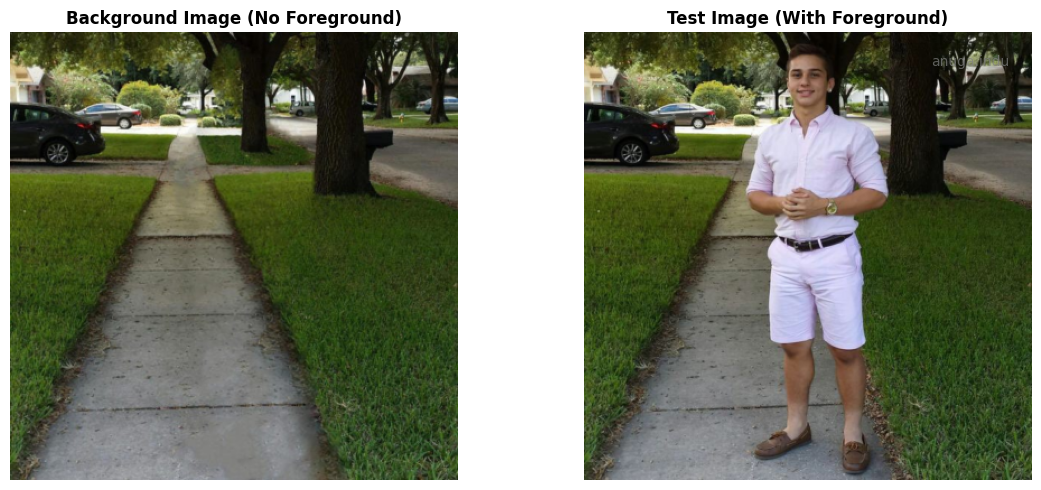

In [4]:
bg_path = 'back.jpg'  
test_path = 'Full.jpg'

bg_img, test_img = load_and_preprocess_images(bg_path, test_path, target_size=(400, 400))

print(f"Background image shape: {bg_img.shape}")
print(f"Test image shape: {test_img.shape}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(bg_img)
axes[0].set_title('Background Image (No Foreground)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(test_img)
axes[1].set_title('Test Image (With Foreground)', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.text(0.95, 0.95, "anuga.indu",
         ha='right', va='top',
         transform=plt.gca().transAxes,
         fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

## Extract RGB features and visualize distributions

Extracting RGB features...
Background features shape: (160000, 3)
Test features shape: (160000, 3)


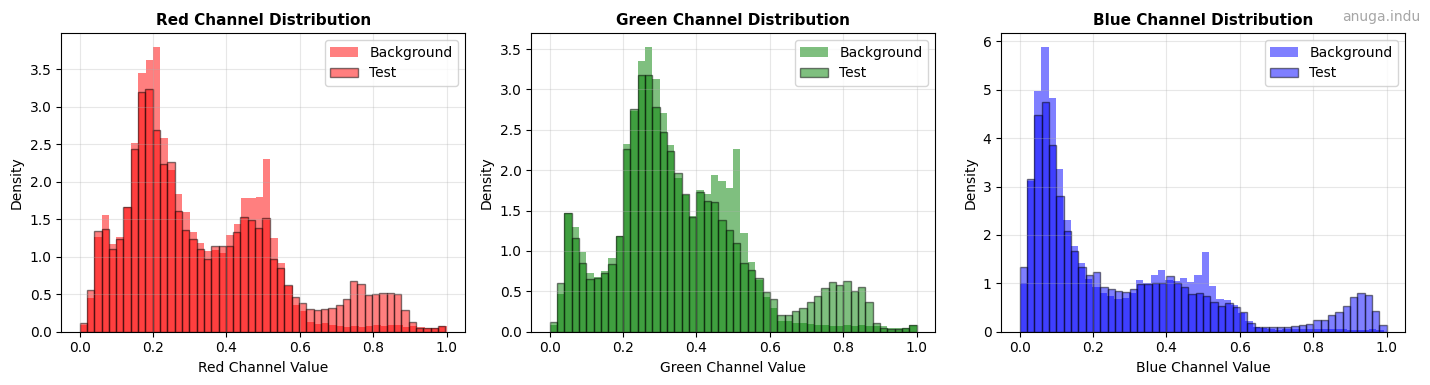

In [5]:
# Extract features from both images
# Using RGB features for best color discrimination
feature_type = 'rgb'

print(f"Extracting {feature_type.upper()} features...")
bg_features = extract_features(bg_img, feature_type=feature_type)
test_features = extract_features(test_img, feature_type=feature_type)

print(f"Background features shape: {bg_features.shape}")
print(f"Test features shape: {test_features.shape}")

# Visualize feature distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

colors = ['red', 'green', 'blue']
channels = ['Red', 'Green', 'Blue']

for i in range(3):
    axes[i].hist(bg_features[:, i], bins=50, alpha=0.5, label='Background', color=colors[i], density=True)
    axes[i].hist(test_features[:, i], bins=50, alpha=0.5, label='Test', color=colors[i], density=True, edgecolor='black')
    axes[i].set_xlabel(f'{channels[i]} Channel Value', fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].set_title(f'{channels[i]} Channel Distribution', fontsize=11, fontweight='bold')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.text(0.95, 0.95, "anuga.indu",
         ha='right', va='top',
         transform=plt.gcf().transFigure,
         fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

## Fit KDE model on background

In [6]:
print("=" * 60)
print("FITTING KDE MODEL")
print("=" * 60)

kernel_type = 'gaussian'       # Options: 'gaussian', 'triangular', 'uniform'
bandwidth = 0.15               # Smoothing parameter
sample_ratio = 0.05            # Use 5% of background pixels overall
sampling_method = 'hybrid'     # Options: 'random', 'grid', 'hybrid'
grid_ratio = 0.6               # For hybrid: 60% grid, 40% random

print(f"\nKernel: {kernel_type}")
print(f"Bandwidth: {bandwidth}")
print(f"Sample ratio: {sample_ratio}")
print(f"Sampling method: {sampling_method}")
if sampling_method == 'hybrid':
    print(f"Grid ratio: {grid_ratio} (Grid={grid_ratio*100:.0f}%, Random={100-grid_ratio*100:.0f}%)")
print()

# Create and fit KDE model
kde = CustomKDE(kernel=kernel_type, bandwidth=bandwidth)

start_time = time.time()

# For hybrid/grid sampling, we need to pass the image shape
if sampling_method in ['hybrid', 'grid']:
    kde.fit(bg_features, 
            img_shape=(bg_img.shape[0], bg_img.shape[1]),
            sample_ratio=sample_ratio,
            sampling_method=sampling_method,
            grid_ratio=grid_ratio)
else:
    kde.fit(bg_features, 
            sample_ratio=sample_ratio,
            sampling_method=sampling_method)

fit_time = time.time() - start_time

print(f"\nFitting completed in {fit_time:.2f} seconds")

FITTING KDE MODEL

Kernel: gaussian
Bandwidth: 0.15
Sample ratio: 0.05
Sampling method: hybrid
Grid ratio: 0.6 (Grid=60%, Random=40%)

Hybrid Sampling Strategy:
  Grid samples: 4800 (60.0%)
  Random samples: 3200 (40.0%)
  Grid step size: 5 pixels
KDE fitted on 8000 samples (from 160000 total)
Feature dimensionality: 3

Fitting completed in 0.01 seconds


Creating sampling visualization...


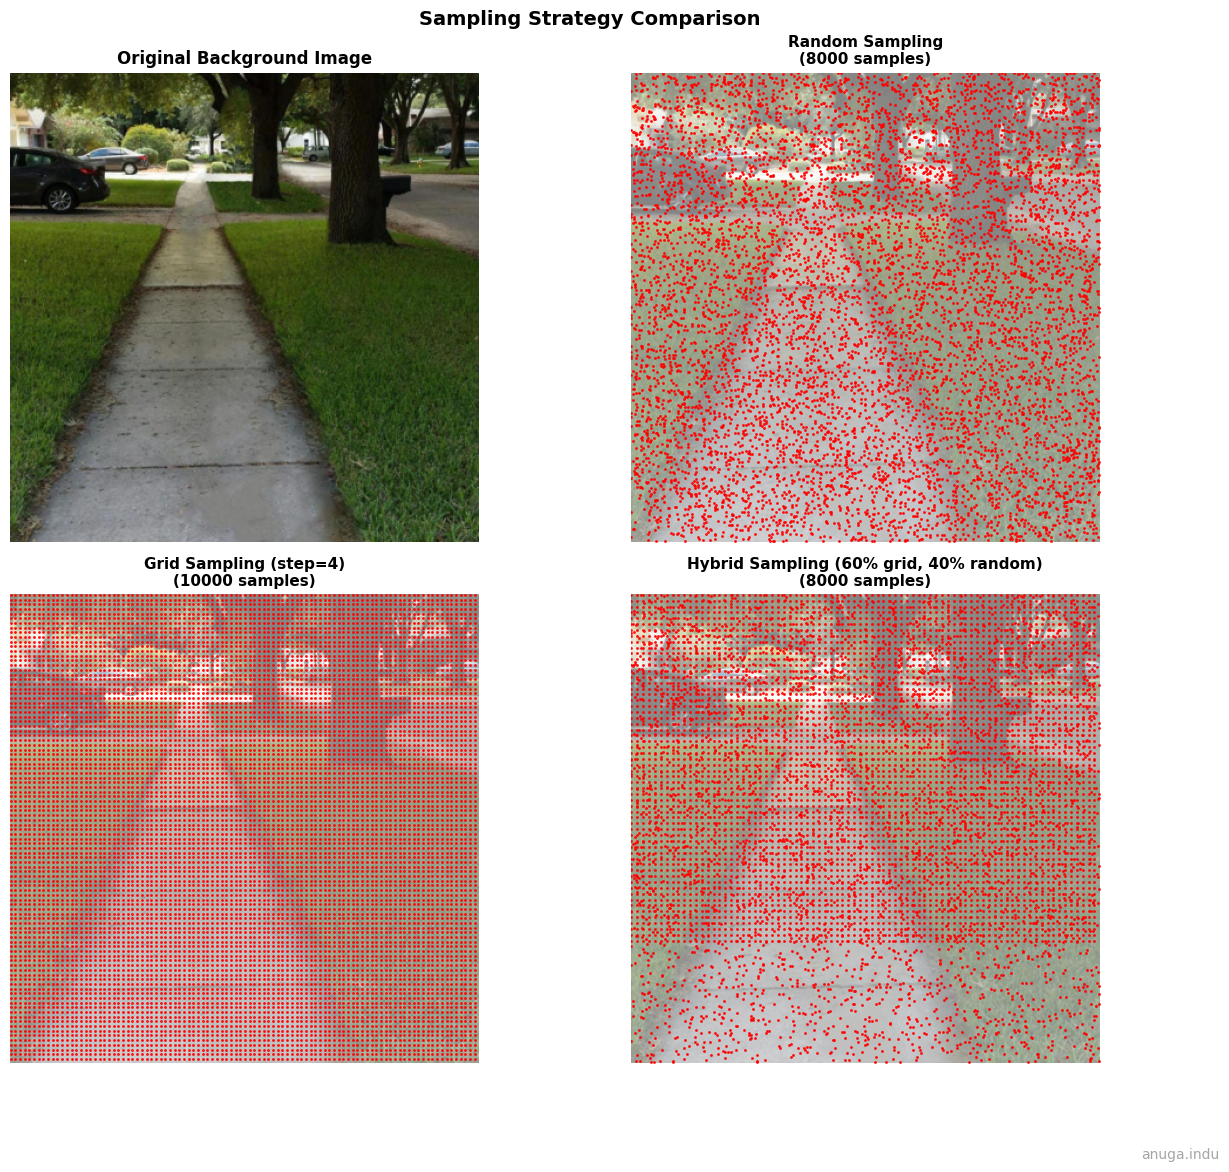

In [7]:
# Visualize different sampling patterns
print("Creating sampling visualization...")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Helper function to get sample positions
def get_sample_positions(data, img_shape, method, ratio, grid_r=0.6):
    n_total = data.shape[0]
    n_samples = max(int(n_total * ratio), 1000)
    height, width = img_shape
    
    if method == 'random':
        indices = np.random.choice(n_total, size=min(n_samples, n_total), replace=False)
        rows = indices // width
        cols = indices % width
        return rows, cols, 'Random Sampling'
    
    elif method == 'grid':
        grid_step = max(1, int(np.sqrt(height * width / n_samples)))
        grid_rows = np.arange(0, height, grid_step)
        grid_cols = np.arange(0, width, grid_step)
        grid_r_idx, grid_c_idx = np.meshgrid(grid_rows, grid_cols, indexing='ij')
        return grid_r_idx.flatten(), grid_c_idx.flatten(), f'Grid Sampling (step={grid_step})'
    
    elif method == 'hybrid':
        n_grid = int(n_samples * grid_r)
        n_random = n_samples - n_grid
        
        # Grid part
        grid_step = max(1, int(np.sqrt(height * width / n_grid)))
        grid_rows = np.arange(0, height, grid_step)
        grid_cols = np.arange(0, width, grid_step)
        grid_r_idx, grid_c_idx = np.meshgrid(grid_rows, grid_cols, indexing='ij')
        grid_r_flat = grid_r_idx.flatten()
        grid_c_flat = grid_c_idx.flatten()
        grid_indices = grid_r_flat * width + grid_c_flat
        grid_indices = grid_indices[grid_indices < n_total][:n_grid]
        
        # Random part
        remaining = np.setdiff1d(np.arange(n_total), grid_indices)
        if len(remaining) >= n_random:
            random_indices = np.random.choice(remaining, size=n_random, replace=False)
        else:
            random_indices = np.random.choice(remaining, size=n_random, replace=True)
        
        all_indices = np.concatenate([grid_indices, random_indices])
        rows = all_indices // width
        cols = all_indices % width
        
        return rows, cols, f'Hybrid Sampling ({grid_r*100:.0f}% grid, {(1-grid_r)*100:.0f}% random)'

# Original image
axes[0, 0].imshow(bg_img)
axes[0, 0].set_title('Original Background Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Different sampling methods
sampling_configs = [
    ('random', 0.05, 0.6),
    ('grid', 0.05, 0.6),
    ('hybrid', 0.05, 0.6)
]

for idx, (method, ratio, grid_r) in enumerate(sampling_configs):
    ax = axes.flatten()[idx + 1]
    
    # Get sample positions
    rows, cols, title = get_sample_positions(
        bg_features, 
        (bg_img.shape[0], bg_img.shape[1]), 
        method, 
        ratio, 
        grid_r
    )
    
    # Plot
    ax.imshow(bg_img, alpha=0.5)
    ax.scatter(cols, rows, c='red', s=5, alpha=0.8, marker='.')
    ax.set_title(f'{title}\n({len(rows)} samples)', fontsize=11, fontweight='bold')
    ax.axis('off')

plt.suptitle('Sampling Strategy Comparison', fontsize=14, fontweight='bold')

plt.text(0.95, 0.02, "anuga.indu",
         ha='right', va='bottom',
         transform=plt.gcf().transFigure,
         fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

## Predict densities for test image

PREDICTING DENSITIES FOR TEST IMAGE
Processed 160000/160000 samples - Complete!

Prediction completed in 47.05 seconds
Total processing time: 47.06 seconds

Density statistics:
  Min density: 0.488682
  Max density: 55.835369
  Mean density: 34.100830
  Median density: 33.296776


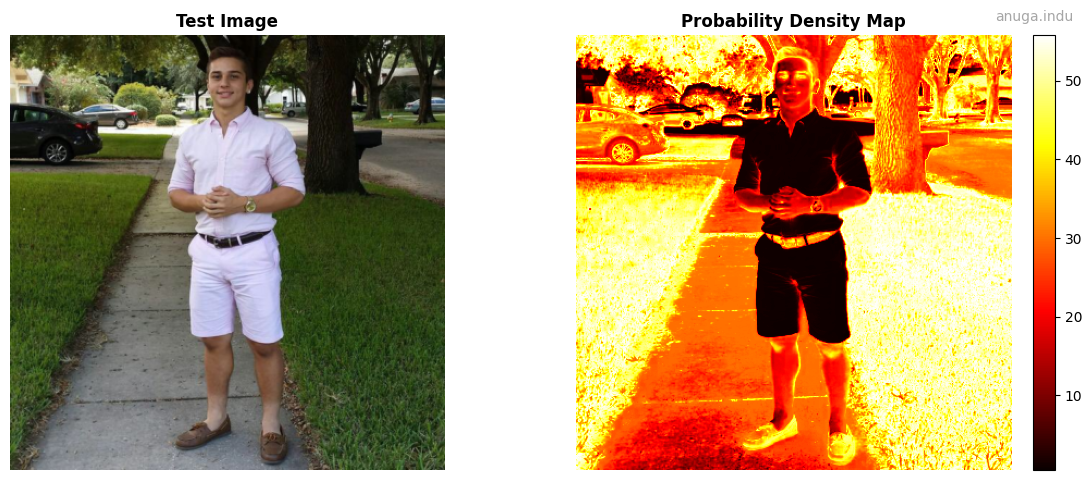

In [8]:
# Predict density values for test image
print("=" * 60)
print("PREDICTING DENSITIES FOR TEST IMAGE")
print("=" * 60)

start_time = time.time()
densities = kde.predict(test_features, batch_size=5000)
predict_time = time.time() - start_time

print(f"\nPrediction completed in {predict_time:.2f} seconds")
print(f"Total processing time: {fit_time + predict_time:.2f} seconds")

# Reshape densities back to image shape
density_map = densities.reshape(test_img.shape[0], test_img.shape[1])

print(f"\nDensity statistics:")
print(f"  Min density: {densities.min():.6f}")
print(f"  Max density: {densities.max():.6f}")
print(f"  Mean density: {densities.mean():.6f}")
print(f"  Median density: {np.median(densities):.6f}")

# Visualize density map
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(test_img)
axes[0].set_title('Test Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

im = axes[1].imshow(density_map, cmap='hot')
axes[1].set_title('Probability Density Map', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.text(0.95, 0.95, "anuga.indu",
         ha='right', va='top',
         transform=plt.gcf().transFigure,
         fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

## Perform foreground segmentation

FOREGROUND DETECTION

Using 20th percentile as threshold: 21.919008
Foreground pixels: 31999 (20.00%)
Background pixels: 128001 (80.00%)


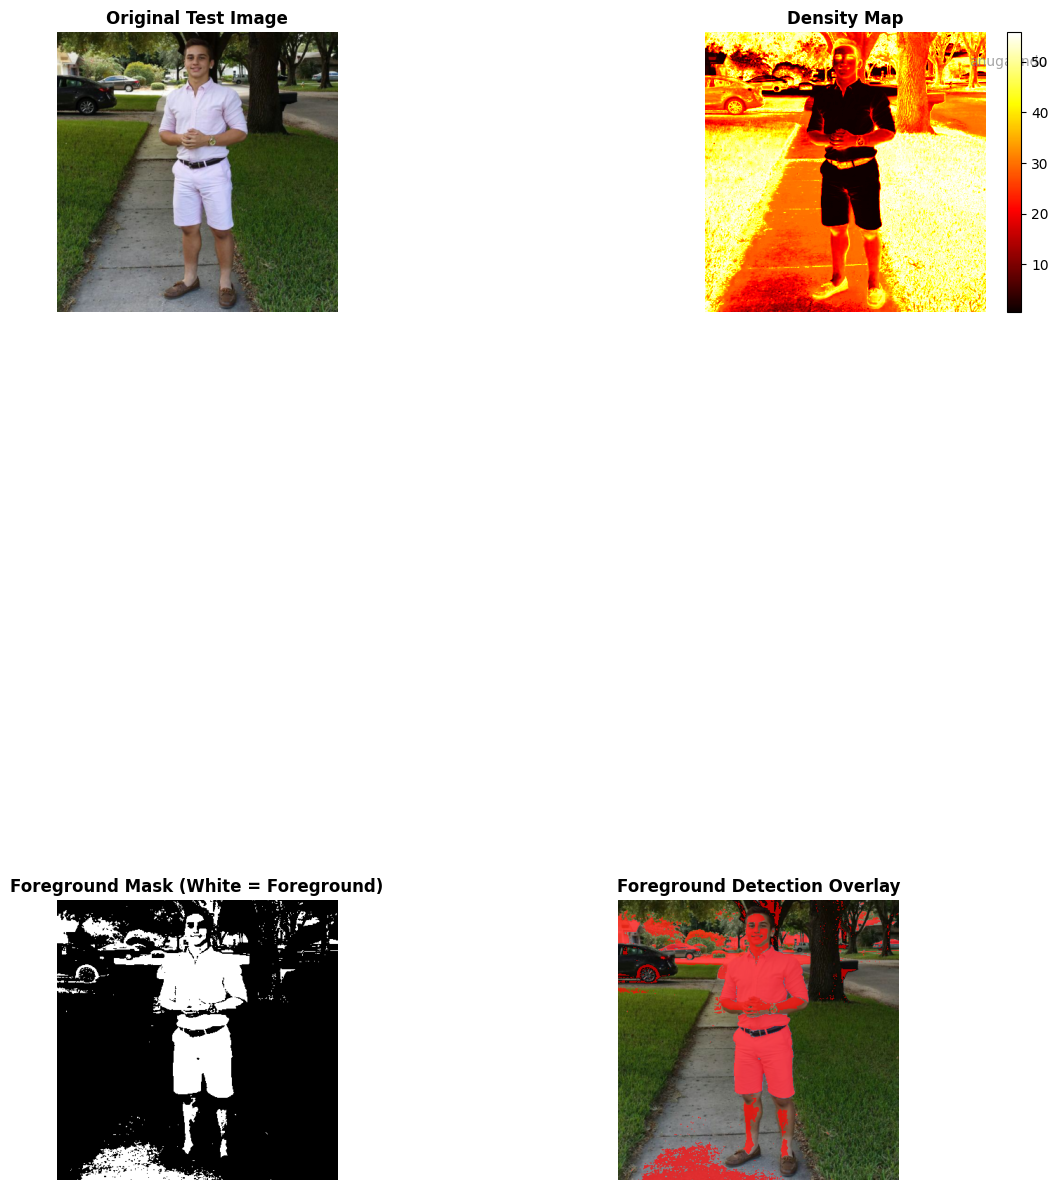

In [9]:
# Foreground detection using threshold
print("=" * 60)
print("FOREGROUND DETECTION")
print("=" * 60)

# Determine threshold
# Pixels with low density are likely foreground (not similar to background)
percentile_threshold = 20  # Use 20th percentile as threshold
threshold = np.percentile(densities, percentile_threshold)
print(f"\nUsing {percentile_threshold}th percentile as threshold: {threshold:.6f}")


# Create binary mask: 0 = foreground, 1 = background
foreground_mask = (densities < threshold).astype(np.uint8)
foreground_mask_2d = foreground_mask.reshape(test_img.shape[0], test_img.shape[1])

# Calculate foreground percentage
fg_percentage = (foreground_mask.sum() / foreground_mask.size) * 100
print(f"Foreground pixels: {foreground_mask.sum()} ({fg_percentage:.2f}%)")
print(f"Background pixels: {(1-foreground_mask).sum()} ({100-fg_percentage:.2f}%)")

# Visualize segmentation results
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Original test image
axes[0, 0].imshow(test_img)
axes[0, 0].set_title('Original Test Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Density map
im1 = axes[0, 1].imshow(density_map, cmap='hot')
axes[0, 1].set_title('Density Map', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

# Binary mask
axes[1, 0].imshow(foreground_mask_2d, cmap='gray')
axes[1, 0].set_title('Foreground Mask (White = Foreground)', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

# Overlay on original
overlay = test_img.copy()
overlay[foreground_mask_2d == 1] = overlay[foreground_mask_2d == 1] * 0.3 + np.array([0.7, 0, 0])
axes[1, 1].imshow(overlay)
axes[1, 1].set_title('Foreground Detection Overlay', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

plt.text(0.95, 0.95, "anuga.indu",
         ha='right', va='top',
         transform=plt.gcf().transFigure,
         fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

## Experiment with different parameters

In [10]:
# Experiment with different parameters
print("=" * 60)
print("PARAMETER EXPERIMENTATION")
print("=" * 60)

# Test different bandwidth values
bandwidths = [0.05, 0.1, 0.15, 0.2, 0.3]
kernels_to_test = ['gaussian', 'triangular', 'uniform']

results = []

for kernel in kernels_to_test:
    for bw in bandwidths:
        print(f"\nTesting: kernel={kernel}, bandwidth={bw}")
        
        # Fit KDE
        kde_test = CustomKDE(kernel=kernel, bandwidth=bw)
        
        # For hybrid/grid sampling
        if sampling_method in ['hybrid', 'grid']:
            kde_test.fit(bg_features, 
                        img_shape=(bg_img.shape[0], bg_img.shape[1]),
                        sample_ratio=sample_ratio,
                        sampling_method=sampling_method,
                        grid_ratio=grid_ratio)
        else:
            kde_test.fit(bg_features, 
                        sample_ratio=sample_ratio,
                        sampling_method=sampling_method)
        
        # Predict
        densities_test = kde_test.predict(test_features, batch_size=5000)
        
        # Threshold at 20th percentile
        thresh = np.percentile(densities_test, 20)

        fg_mask = (densities_test < thresh).astype(np.uint8)
        fg_pct = (fg_mask.sum() / fg_mask.size) * 100
        
        results.append({
            'kernel': kernel,
            'bandwidth': bw,
            'threshold': thresh,
            'fg_percentage': fg_pct,
            'densities': densities_test
        })
        
        print(f"  Foreground: {fg_pct:.2f}%")

print("\n" + "=" * 60)
print("EXPERIMENT RESULTS SUMMARY")
print("=" * 60)
for r in results:
    print(f"Kernel: {r['kernel']:11s} | BW: {r['bandwidth']:.2f} | FG: {r['fg_percentage']:5.2f}%")

PARAMETER EXPERIMENTATION

Testing: kernel=gaussian, bandwidth=0.05
Hybrid Sampling Strategy:
  Grid samples: 4800 (60.0%)
  Random samples: 3200 (40.0%)
  Grid step size: 5 pixels
KDE fitted on 8000 samples (from 160000 total)
Feature dimensionality: 3
Processed 160000/160000 samples - Complete!
  Foreground: 19.99%

Testing: kernel=gaussian, bandwidth=0.1
Hybrid Sampling Strategy:
  Grid samples: 4800 (60.0%)
  Random samples: 3200 (40.0%)
  Grid step size: 5 pixels
KDE fitted on 8000 samples (from 160000 total)
Feature dimensionality: 3
Processed 160000/160000 samples - Complete!
  Foreground: 20.00%

Testing: kernel=gaussian, bandwidth=0.15
Hybrid Sampling Strategy:
  Grid samples: 4800 (60.0%)
  Random samples: 3200 (40.0%)
  Grid step size: 5 pixels
KDE fitted on 8000 samples (from 160000 total)
Feature dimensionality: 3
Processed 160000/160000 samples - Complete!
  Foreground: 20.00%

Testing: kernel=gaussian, bandwidth=0.2
Hybrid Sampling Strategy:
  Grid samples: 4800 (60.0%)


## Visualize parameter comparison

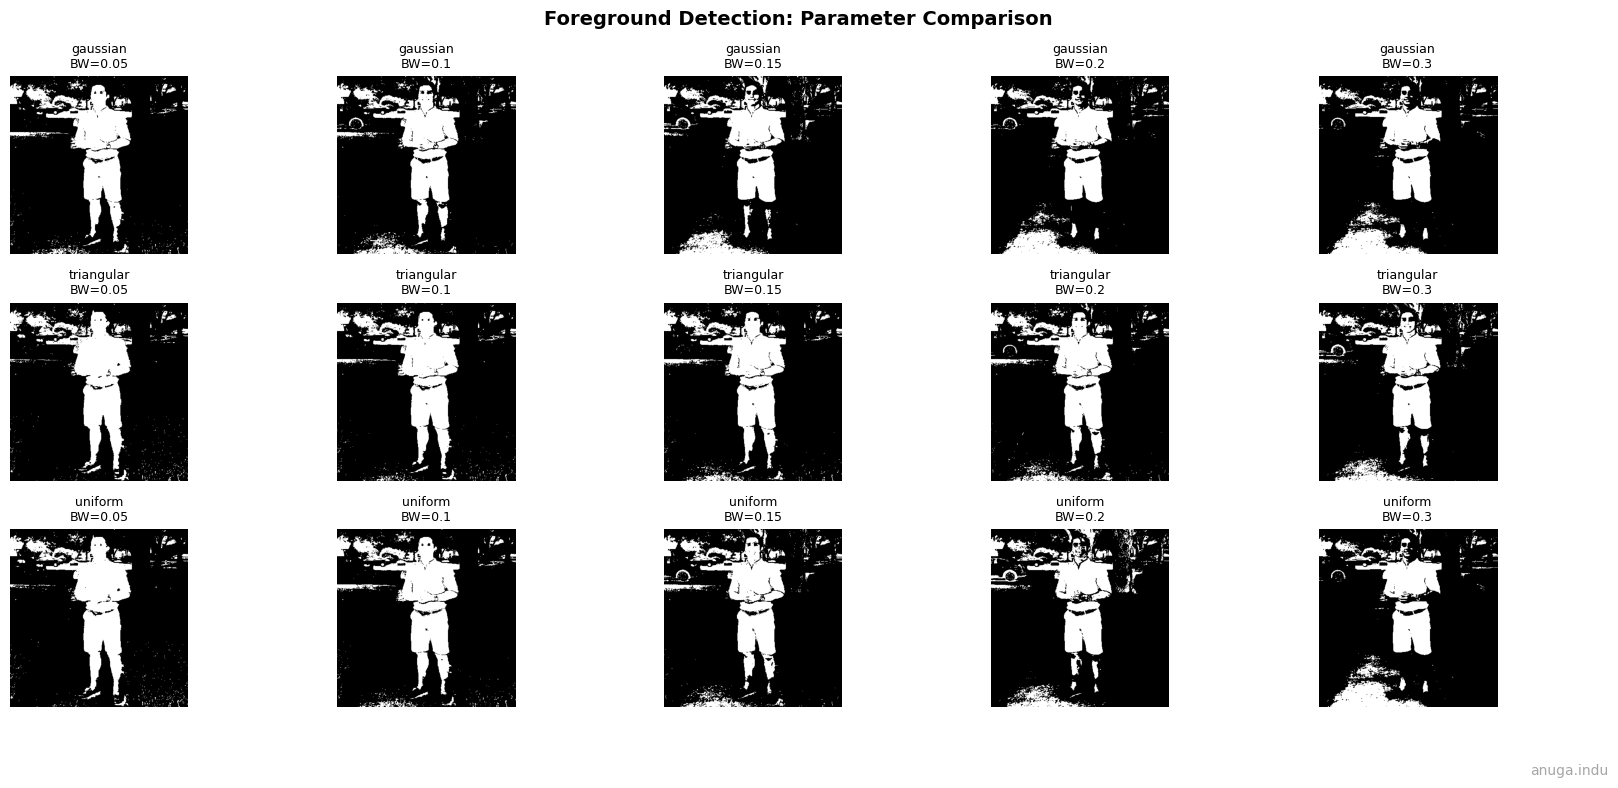

In [11]:
# Visualize results for different parameters
fig, axes = plt.subplots(len(kernels_to_test), len(bandwidths), figsize=(18, 8))

for i, kernel in enumerate(kernels_to_test):
    for j, bw in enumerate(bandwidths):
        # Find result
        result = [r for r in results if r['kernel'] == kernel and r['bandwidth'] == bw][0]
        
        # Create mask
        thresh = np.percentile(result['densities'], 20)
        mask = (result['densities'] < thresh).reshape(test_img.shape[0], test_img.shape[1])
        
        # Plot
        ax = axes[i, j] if len(kernels_to_test) > 1 else axes[j]
        ax.imshow(mask, cmap='gray')
        ax.set_title(f'{kernel}\nBW={bw}', fontsize=9)
        ax.axis('off')

plt.suptitle('Foreground Detection: Parameter Comparison', 
             fontsize=14, fontweight='bold', y=0.98)

plt.text(0.95, 0.02, "anuga.indu",
         ha='right', va='bottom',
         transform=plt.gcf().transFigure,
         fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

## Find best parameter combination


Analyzing: GAUSSIAN | Bandwidth: 0.05
  [1/45] Percentile: 15% | FG: 15.00% | Score: 0.816
  [2/45] Percentile: 20% | FG: 19.99% | Score: 0.895
  [3/45] Percentile: 25% | FG: 24.99% | Score: 0.767

Analyzing: GAUSSIAN | Bandwidth: 0.1
  [4/45] Percentile: 15% | FG: 15.00% | Score: 0.805
  [5/45] Percentile: 20% | FG: 20.00% | Score: 0.883
  [6/45] Percentile: 25% | FG: 25.00% | Score: 0.760

Analyzing: GAUSSIAN | Bandwidth: 0.15
  [7/45] Percentile: 15% | FG: 14.98% | Score: 0.798
  [8/45] Percentile: 20% | FG: 20.00% | Score: 0.878
  [9/45] Percentile: 25% | FG: 24.98% | Score: 0.767

Analyzing: GAUSSIAN | Bandwidth: 0.2
  [10/45] Percentile: 15% | FG: 15.00% | Score: 0.799
  [11/45] Percentile: 20% | FG: 20.00% | Score: 0.887
  [12/45] Percentile: 25% | FG: 24.99% | Score: 0.769

Analyzing: GAUSSIAN | Bandwidth: 0.3
  [13/45] Percentile: 15% | FG: 15.00% | Score: 0.798
  [14/45] Percentile: 20% | FG: 19.97% | Score: 0.886
  [15/45] Percentile: 25% | FG: 25.00% | Score: 0.767

Analyz

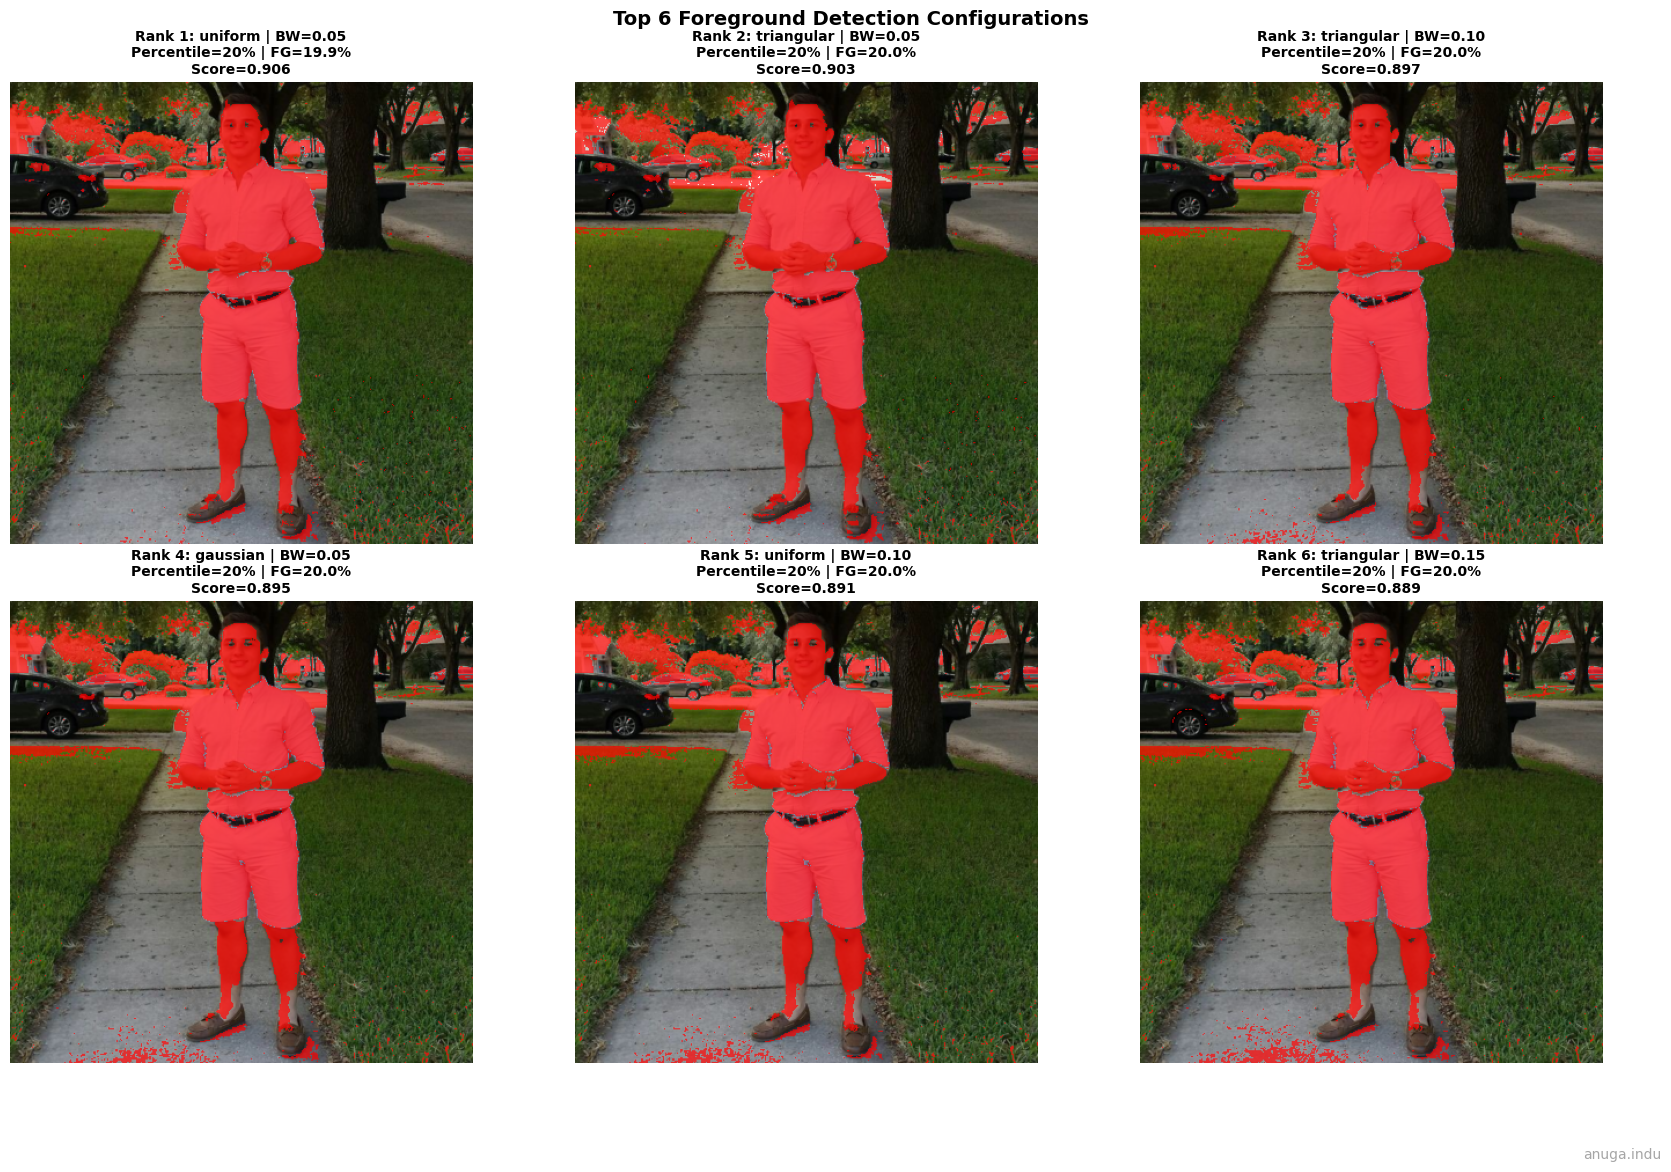


Generating best vs worst comparison...


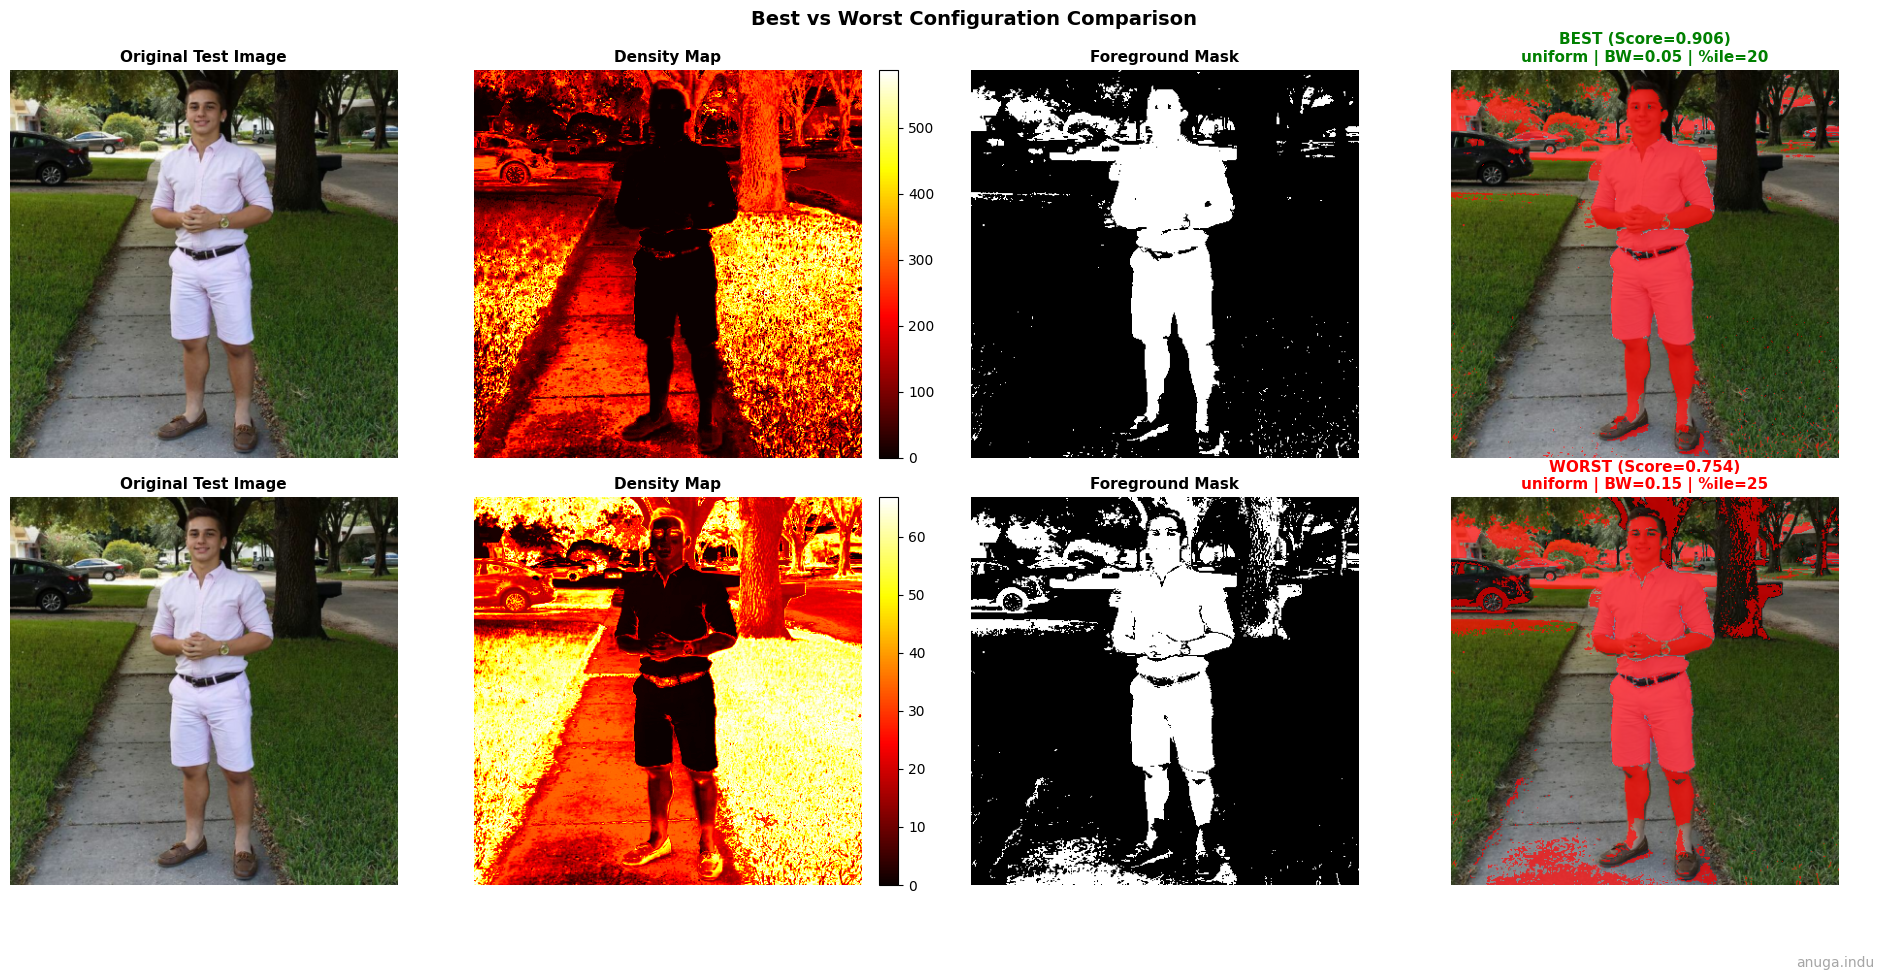


Generating score distribution analysis...


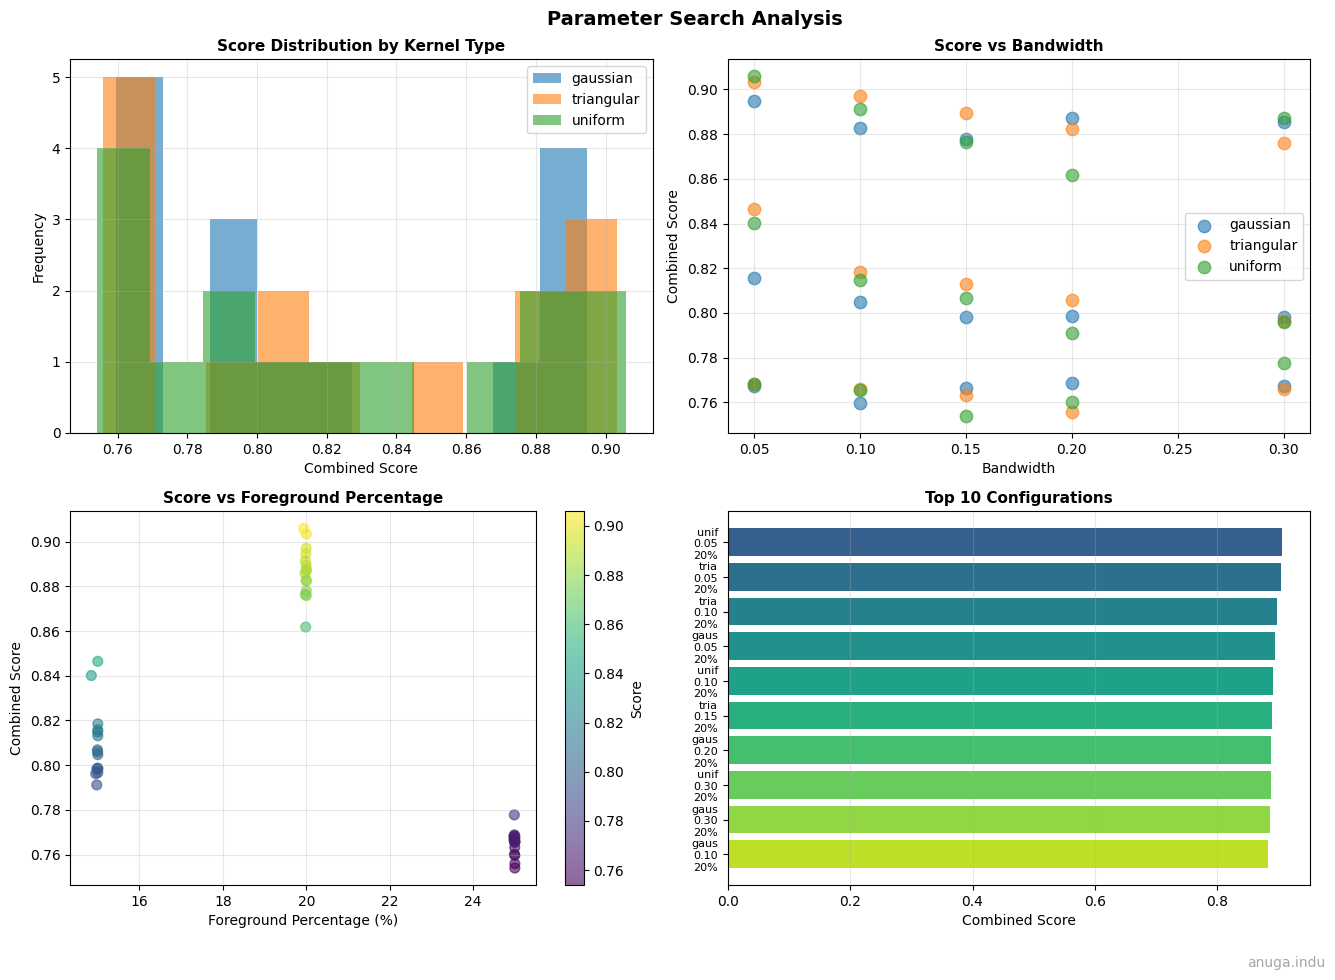


ANALYSIS COMPLETE

Best Configuration Found:
  UNIFORM kernel with bandwidth 0.05
  Using 20% threshold percentile
  Achieves combined quality score of 0.9059


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion, binary_dilation

def calculate_quality_metrics(foreground_mask, density_map):
    """
    Calculate quality metrics for foreground detection.
    
    Metrics:
    - Compactness: How compact is the foreground region
    - Edge strength: Difference in density between foreground and background
    - Size ratio: Percentage of image classified as foreground
    - Density separation: How well separated are fg and bg densities
    """
    fg_pixels = foreground_mask.sum()
    total_pixels = foreground_mask.size
    
    # Size ratio (should be reasonable, not too small or large)
    size_ratio = fg_pixels / total_pixels
    
    # Density separation (higher is better)
    fg_densities = density_map[foreground_mask == 1]
    bg_densities = density_map[foreground_mask == 0]
    
    if len(fg_densities) > 0 and len(bg_densities) > 0:
        density_separation = np.abs(np.mean(bg_densities) - np.mean(fg_densities))
    else:
        density_separation = 0
    
    # Compactness (perimeter^2 / area, lower is better for compact regions)
    # Use morphological operations to find perimeter
    eroded = binary_erosion(foreground_mask)
    perimeter_pixels = np.sum(foreground_mask) - np.sum(eroded)
    
    if fg_pixels > 0:
        compactness = (perimeter_pixels ** 2) / (fg_pixels + 1e-8)
    else:
        compactness = float('inf')
    
    # Combined score (normalized)
    # Good detection: reasonable size (10-30%), high separation, low compactness
    size_score = 1.0 - abs(size_ratio - 0.20) / 0.20  # Optimal around 20%
    separation_score = min(density_separation * 100, 1.0)  # Normalize
    compactness_score = 1.0 / (1.0 + compactness / 1000)  # Lower is better
    
    combined_score = (size_score * 0.4 + separation_score * 0.4 + compactness_score * 0.2)
    
    return {
        'size_ratio': size_ratio,
        'density_separation': density_separation,
        'compactness': compactness,
        'size_score': size_score,
        'separation_score': separation_score,
        'compactness_score': compactness_score,
        'combined_score': combined_score
    }


# Test different threshold percentiles for existing results
percentiles_to_test = [15, 20, 25]

all_enhanced_results = []
best_score = -float('inf')
best_config = None

total_configs = len(results) * len(percentiles_to_test)
current_config = 0

for result in results:
    kernel = result['kernel']
    bw = result['bandwidth']
    densities_existing = result['densities']
    
    print(f"\nAnalyzing: {kernel.upper()} | Bandwidth: {bw}")
    
    density_map_existing = densities_existing.reshape(test_img.shape[0], test_img.shape[1])
    
    # Try different percentile thresholds
    for percentile in percentiles_to_test:
        current_config += 1
        
        # Compute threshold and mask
        thresh = np.percentile(densities_existing, percentile)
        fg_mask = (densities_existing < thresh).astype(np.uint8)
        fg_mask_2d = fg_mask.reshape(test_img.shape[0], test_img.shape[1])
        
        # Calculate quality metrics
        metrics = calculate_quality_metrics(fg_mask_2d, density_map_existing)
        
        # Store enhanced results
        enhanced_result = {
            'kernel': kernel,
            'bandwidth': bw,
            'percentile': percentile,
            'threshold': thresh,
            'fg_percentage': metrics['size_ratio'] * 100,
            'densities': densities_existing,
            'mask': fg_mask_2d,
            **metrics
        }
        all_enhanced_results.append(enhanced_result)
        
        # Check if this is the best so far
        if metrics['combined_score'] > best_score:
            best_score = metrics['combined_score']
            best_config = enhanced_result
        
        # Print progress
        print(f"  [{current_config}/{total_configs}] Percentile: {percentile}% | "
              f"FG: {metrics['size_ratio']*100:5.2f}% | "
              f"Score: {metrics['combined_score']:.3f}")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE - TOP 10 CONFIGURATIONS")
print("=" * 70)

# Sort by combined score
all_results_sorted = sorted(all_enhanced_results, key=lambda x: x['combined_score'], reverse=True)

print(f"\n{'Rank':<6} {'Kernel':<12} {'BW':<6} {'%ile':<6} {'FG%':<8} "
      f"{'Sep':<8} {'Comp':<8} {'Score':<8}")
print("-" * 70)

for rank, result in enumerate(all_results_sorted[:10], 1):
    print(f"{rank:<6} {result['kernel']:<12} {result['bandwidth']:<6.2f} "
          f"{result['percentile']:<6} {result['fg_percentage']:<8.2f} "
          f"{result['density_separation']:<8.4f} "
          f"{result['compactness']:<8.1f} "
          f"{result['combined_score']:<8.3f}")

print("\n" + "=" * 70)
print("BEST CONFIGURATION DETAILS")
print("=" * 70)
print(f"Kernel: {best_config['kernel']}")
print(f"Bandwidth: {best_config['bandwidth']}")
print(f"Percentile Threshold: {best_config['percentile']}%")
print(f"Threshold Value: {best_config['threshold']:.6f}")
print(f"Foreground Percentage: {best_config['fg_percentage']:.2f}%")
print(f"\nQuality Metrics:")
print(f"  Density Separation: {best_config['density_separation']:.6f}")
print(f"  Compactness: {best_config['compactness']:.2f}")
print(f"  Combined Score: {best_config['combined_score']:.4f}")
print(f"\nComponent Scores:")
print(f"  Size Score: {best_config['size_score']:.3f}")
print(f"  Separation Score: {best_config['separation_score']:.3f}")
print(f"  Compactness Score: {best_config['compactness_score']:.3f}")

print("\n" + "=" * 70)
print("WHY THIS COMBINATION IS BEST:")
print("=" * 70)
print(f"1. Kernel Choice ({best_config['kernel']}):")
if best_config['kernel'] == 'gaussian':
    print("   - Smooth density estimates without hard boundaries")
    print("   - Handles continuous color transitions naturally")
    print("   - Mathematically well-behaved for probability distributions")
elif best_config['kernel'] == 'triangular':
    print("   - Compact support reduces computational cost")
    print("   - Linear decay provides moderate smoothing")
    print("   - Good balance between Gaussian and Uniform")
else:  # uniform
    print("   - Simplest kernel with constant weights")
    print("   - Fast computation")
    print("   - Works well for distinct color separations")

print(f"\n2. Bandwidth ({best_config['bandwidth']}):")
if best_config['bandwidth'] < 0.1:
    print("   - Low bandwidth → More sensitive to local variations")
    print("   - Captures fine details but may be noisy")
elif best_config['bandwidth'] > 0.2:
    print("   - High bandwidth → More smoothing")
    print("   - Robust but may miss small objects")
else:
    print("   - Moderate bandwidth → Balanced approach")
    print("   - Captures background distribution while detecting foreground")
    print("   - Optimal for RGB [0,1] normalized space")

print(f"\n3. Threshold Percentile ({best_config['percentile']}%):")
print(f"   - Classifies bottom {best_config['percentile']}% densities as foreground")
print(f"   - Adaptive to actual density distribution")
print(f"   - Results in {best_config['fg_percentage']:.1f}% foreground pixels")

## Visualize top 6 configurations

print("\nGenerating comparison visualization...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx in range(6):
    if idx < len(all_results_sorted):
        result = all_results_sorted[idx]
        
        # Create overlay
        overlay = test_img.copy()
        overlay[result['mask'] == 1] = overlay[result['mask'] == 1] * 0.3 + np.array([0.7, 0, 0])
        
        axes[idx].imshow(overlay)
        axes[idx].set_title(
            f"Rank {idx+1}: {result['kernel']} | BW={result['bandwidth']:.2f}\n"
            f"Percentile={result['percentile']}% | FG={result['fg_percentage']:.1f}%\n"
            f"Score={result['combined_score']:.3f}",
            fontsize=10, fontweight='bold'
        )
        axes[idx].axis('off')
    else:
        axes[idx].axis('off')

plt.suptitle('Top 6 Foreground Detection Configurations', 
             fontsize=14, fontweight='bold')

plt.text(0.95, 0.02, "anuga.indu",
         ha='right', va='bottom',
         transform=plt.gcf().transFigure,
         fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

## Detailed comparison of best vs worst

print("\nGenerating best vs worst comparison...")

best_result = all_results_sorted[0]
worst_result = all_results_sorted[-1]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# BEST Configuration - Row 0
axes[0, 0].imshow(test_img)
axes[0, 0].set_title('Original Test Image', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

im1 = axes[0, 1].imshow(best_result['densities'].reshape(test_img.shape[:2]), cmap='hot')
axes[0, 1].set_title('Density Map', fontsize=11, fontweight='bold')
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

axes[0, 2].imshow(best_result['mask'], cmap='gray')
axes[0, 2].set_title('Foreground Mask', fontsize=11, fontweight='bold')
axes[0, 2].axis('off')

overlay_best = test_img.copy()
overlay_best[best_result['mask'] == 1] = overlay_best[best_result['mask'] == 1] * 0.3 + np.array([0.7, 0, 0])
axes[0, 3].imshow(overlay_best)
axes[0, 3].set_title(
    f"BEST (Score={best_result['combined_score']:.3f})\n"
    f"{best_result['kernel']} | BW={best_result['bandwidth']:.2f} | "
    f"%ile={best_result['percentile']}",
    fontsize=11, fontweight='bold', color='green'
)
axes[0, 3].axis('off')

# WORST Configuration - Row 1
axes[1, 0].imshow(test_img)
axes[1, 0].set_title('Original Test Image', fontsize=11, fontweight='bold')
axes[1, 0].axis('off')

im2 = axes[1, 1].imshow(worst_result['densities'].reshape(test_img.shape[:2]), cmap='hot')
axes[1, 1].set_title('Density Map', fontsize=11, fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1], fraction=0.046, pad=0.04)

axes[1, 2].imshow(worst_result['mask'], cmap='gray')
axes[1, 2].set_title('Foreground Mask', fontsize=11, fontweight='bold')
axes[1, 2].axis('off')

overlay_worst = test_img.copy()
overlay_worst[worst_result['mask'] == 1] = overlay_worst[worst_result['mask'] == 1] * 0.3 + np.array([0.7, 0, 0])
axes[1, 3].imshow(overlay_worst)
axes[1, 3].set_title(
    f"WORST (Score={worst_result['combined_score']:.3f})\n"
    f"{worst_result['kernel']} | BW={worst_result['bandwidth']:.2f} | "
    f"%ile={worst_result['percentile']}",
    fontsize=11, fontweight='bold', color='red'
)
axes[1, 3].axis('off')

plt.suptitle('Best vs Worst Configuration Comparison', 
             fontsize=14, fontweight='bold')

plt.text(0.95, 0.02, "anuga.indu",
         ha='right', va='bottom',
         transform=plt.gcf().transFigure,
         fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

## Score distribution analysis

print("\nGenerating score distribution analysis...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Combined score by kernel
for kernel in kernels_to_test:
    kernel_results = [r for r in all_enhanced_results if r['kernel'] == kernel]
    scores = [r['combined_score'] for r in kernel_results]
    axes[0, 0].hist(scores, alpha=0.6, label=kernel, bins=10)

axes[0, 0].set_xlabel('Combined Score', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].set_title('Score Distribution by Kernel Type', fontsize=11, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Score vs Bandwidth
for kernel in kernels_to_test:
    kernel_results = [r for r in all_enhanced_results if r['kernel'] == kernel]
    bws = [r['bandwidth'] for r in kernel_results]
    scores = [r['combined_score'] for r in kernel_results]
    axes[0, 1].scatter(bws, scores, label=kernel, alpha=0.6, s=80)

axes[0, 1].set_xlabel('Bandwidth', fontsize=10)
axes[0, 1].set_ylabel('Combined Score', fontsize=10)
axes[0, 1].set_title('Score vs Bandwidth', fontsize=11, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Foreground percentage vs Score
fg_pcts = [r['fg_percentage'] for r in all_enhanced_results]
scores = [r['combined_score'] for r in all_enhanced_results]
scatter = axes[1, 0].scatter(fg_pcts, scores, alpha=0.6, s=50, c=scores, cmap='viridis')
axes[1, 0].set_xlabel('Foreground Percentage (%)', fontsize=10)
axes[1, 0].set_ylabel('Combined Score', fontsize=10)
axes[1, 0].set_title('Score vs Foreground Percentage', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Score')

# Top 10 configurations bar chart
top10 = all_results_sorted[:10]
labels = [f"{r['kernel'][:4]}\n{r['bandwidth']:.2f}\n{r['percentile']}%" for r in top10]
scores = [r['combined_score'] for r in top10]
colors_bar = plt.cm.viridis(np.linspace(0.3, 0.9, 10))

axes[1, 1].barh(range(10), scores, color=colors_bar)
axes[1, 1].set_yticks(range(10))
axes[1, 1].set_yticklabels(labels, fontsize=8)
axes[1, 1].set_xlabel('Combined Score', fontsize=10)
axes[1, 1].set_title('Top 10 Configurations', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='x')
axes[1, 1].invert_yaxis()

plt.suptitle('Parameter Search Analysis', fontsize=14, fontweight='bold')

plt.text(0.95, 0.02, "anuga.indu",
         ha='right', va='bottom',
         transform=plt.gcf().transFigure,
         fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)
print(f"\nBest Configuration Found:")
print(f"  {best_config['kernel'].upper()} kernel with bandwidth {best_config['bandwidth']}")
print(f"  Using {best_config['percentile']}% threshold percentile")
print(f"  Achieves combined quality score of {best_config['combined_score']:.4f}")